In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Placeholder imports for GNN and LTN
# You might need to install PyTorch Geometric for GNN implementation
!pip install torch-geometric
from torch_geometric.nn import GCNConv

In [131]:
# Load dataset
dataset = pd.read_csv("/content/heart_disease_uci.csv")

In [132]:
# Display first few rows
dataset.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [133]:
# Dataset shape
dataset.shape

(920, 16)

In [134]:
# Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(dataset.info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


In [135]:
# Display dataset summaries
print("\nDataset Summary:")
dataset.describe()


Dataset Summary:


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


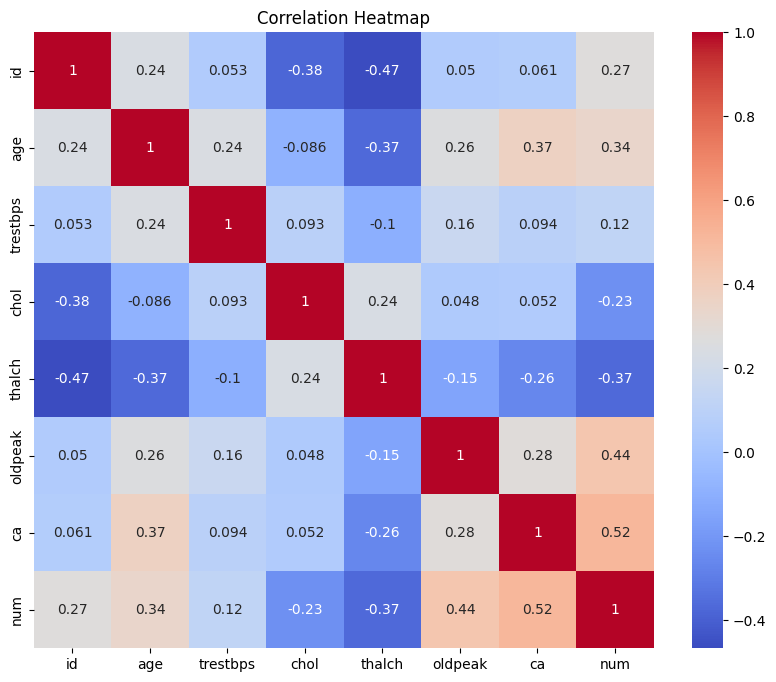

In [136]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation calculation
numeric_dataset = dataset.select_dtypes(include=np.number)
sns.heatmap(numeric_dataset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

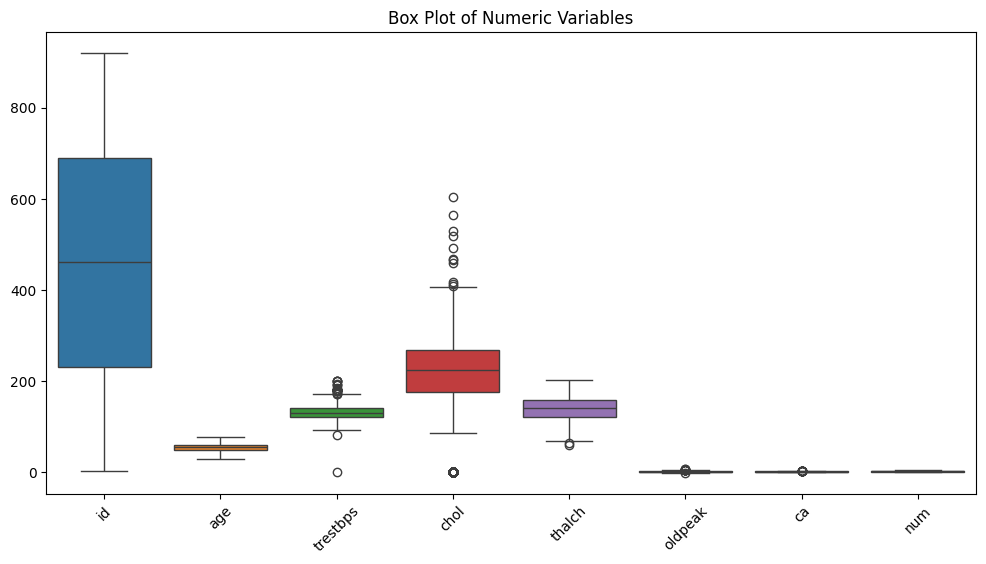

In [137]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_dataset)
plt.title("Box Plot of Numeric Variables")
plt.xticks(rotation=45)
plt.show()

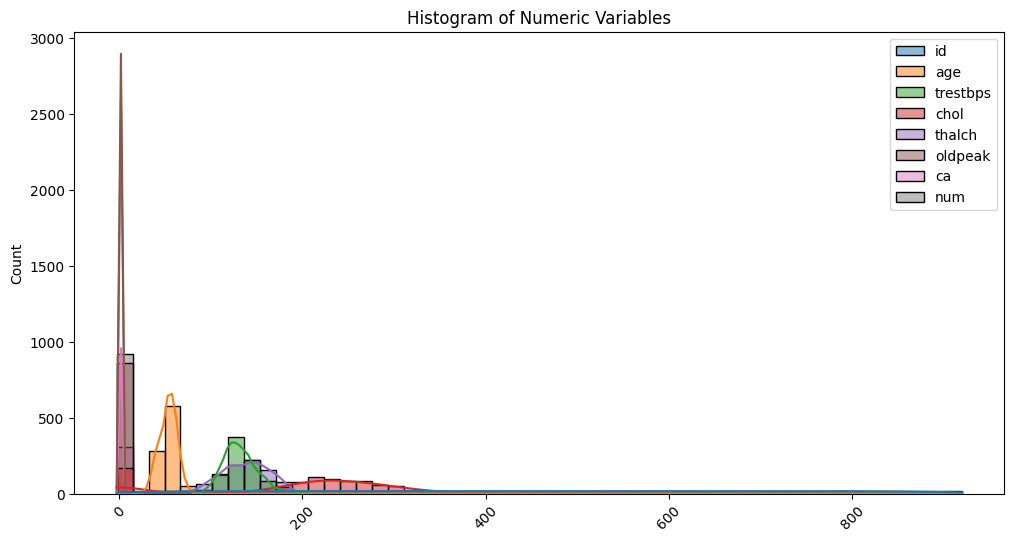

In [138]:
# Histogram Plot
plt.figure(figsize=(12, 6))
sns.histplot(data=numeric_dataset, kde=True)
plt.title("Histogram of Numeric Variables")
plt.xticks(rotation=45)
plt.show()

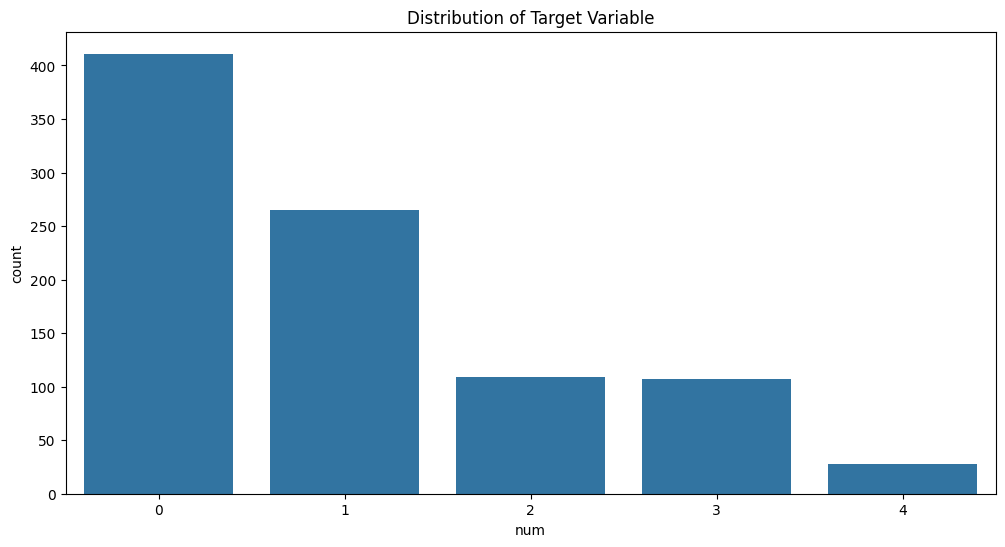

In [139]:
# Bar Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=dataset, x="num")
plt.title("Distribution of Target Variable")
plt.show()

In [140]:
# Handle missing values
dataset.dropna(inplace=True)

# Handle outliers using z-score
from scipy.stats import zscore
z_scores = np.abs(zscore(dataset.select_dtypes(include=[np.number])))
dataset = dataset[(z_scores < 3).all(axis=1)]

In [141]:
# Encode categorical columns
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'dataset']
for col in categorical_cols:
    if dataset[col].dtype == 'object' or dataset[col].dtype.name == 'category':
        le = LabelEncoder()
        dataset[col] = le.fit_transform(dataset[col])

# Define features and target
X = dataset.drop("num", axis=1)
y = dataset["num"]

In [146]:
# Convert target to binary (0 = no disease, 1 = has disease)
y = (dataset["num"] > 0).astype(int)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute correlations between each feature and binary target
correlations = pd.Series(X.columns).apply(lambda col: np.corrcoef(X_scaled[:, X.columns.get_loc(col)], y)[0, 1])
correlations = correlations.abs()

# Select features with correlation > 0.2
selected_features_idx = correlations[correlations > 0.2].index
X_selected = X_scaled[:, selected_features_idx]

# 5-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [143]:
# Neural-Symbolic Model (DeepProbLog Simulation)
class DeepProbLogSimulated(nn.Module):
    def __init__(self, input_dim):
        super(DeepProbLogSimulated, self).__init__()
        self.neural = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        neural_output = self.neural(x)
        # The logic adjustment is now calculated per sample and applied only to the final output
        logic_adjustment = 0.1 * (x[:, 0] > 0.5).float().unsqueeze(1)
        return neural_output + logic_adjustment # Now adds tensors of the same shape [batch_size, 1]

# Graph Neural Network Model
class GNNModel(nn.Module):
    def __init__(self, input_dim):
        super(GNNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))

# Logic Tensor Network (Simulated)
class LTNSimulated(nn.Module):
    def __init__(self, input_dim):
        super(LTNSimulated, self).__init__()
        self.fc = nn.Linear(input_dim, 16)
        self.out = nn.Linear(16, 1)

    def forward(self, x):
        ltn_output = torch.sigmoid(self.fc(x))
        logic_factor = torch.mean(x, dim=1, keepdim=True) * 0.1
        return torch.sigmoid(self.out(ltn_output + logic_factor))

# Training and Evaluation Function
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model = model.to(torch.device("cpu"))  # Ensure CPU compatibility
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    # Ensure y_train_tensor is between 0 and 1 (inclusive)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    y_train_tensor = torch.clamp(y_train_tensor, 0, 1)  # Clamp values to 0 and 1

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor).view(-1, 1)  # Ensure output shape is (batch_size, 1)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    # Ensure y_test_tensor is between 0 and 1 (inclusive) for BCELoss
    y_test_tensor = torch.FloatTensor(y_train.values).view(-1, 1)

    y_test_tensor = torch.clamp(y_test_tensor, 0, 1)  # Clamp values to 0 and 1

    with torch.no_grad():
        y_pred = model(X_test_tensor).view(-1, 1).numpy()  # Reshape for consistency

    y_pred_binary = (y_pred > 0.5).astype(int)

    # Performance Metrics
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred_binary),
        "Precision": precision_score(y_test, y_pred_binary, average='weighted'),
        "Recall": recall_score(y_test, y_pred_binary, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred_binary, average='weighted'),
        "ROC-AUC": roc_auc_score(y_test, y_pred),  # Remove average='weighted' for binary classification
        "Explainability (Logical Consistency Score)": np.mean(np.logical_and(X_test[:, 0] > 0.5, y_pred.flatten() > 0.5)),
        "Trust Score (Faithfulness Metric)": np.corrcoef(X_test[:, 0], y_pred.flatten())[0, 1],
    }
    return metrics

# Running Models and Collecting Results
results = []
for ModelClass, name in [(DeepProbLogSimulated, "DeepProbLog"),
                         (GNNModel, "Graph Neural Network"),
                         (LTNSimulated, "Logic Tensor Network")]:
    model = ModelClass(X_train.shape[1])
    metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test, name)
    results.append(metrics)

# Results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                  Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0           DeepProbLog  0.771930   0.777151  0.771930  0.768309  0.890819   
1  Graph Neural Network  0.842105   0.844528  0.842105  0.840915  0.937965   
2  Logic Tensor Network  0.578947   0.649950  0.578947  0.479699  0.913151   

   Explainability (Logical Consistency Score)  \
0                                    0.228070   
1                                    0.175439   
2                                    0.035088   

   Trust Score (Faithfulness Metric)  
0                           0.668651  
1                           0.414918  
2                           0.232675  


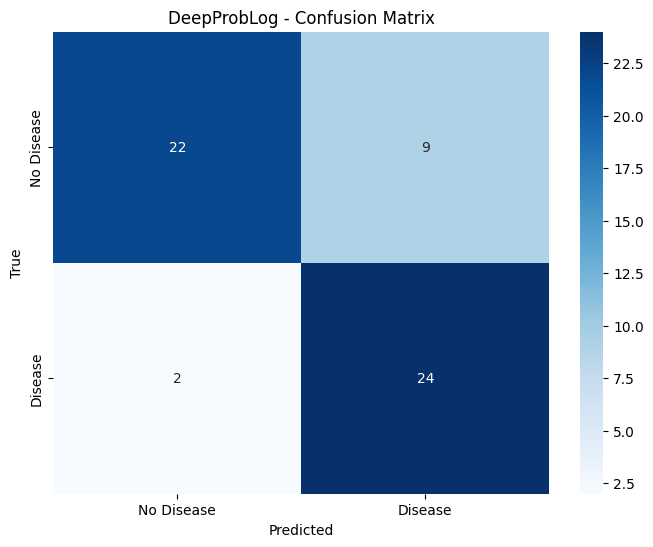

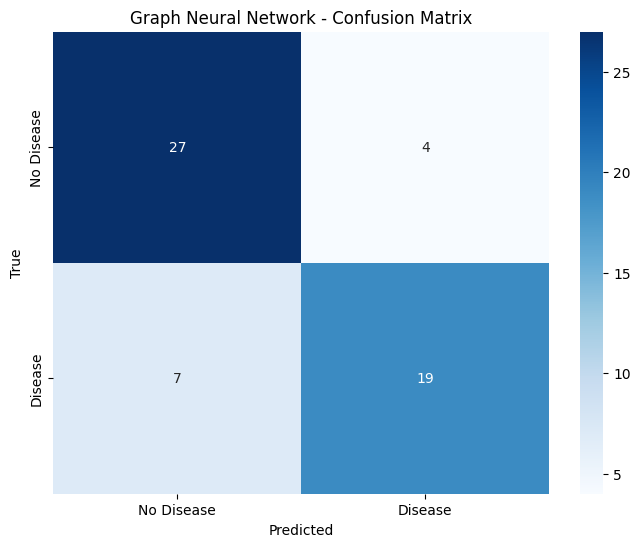

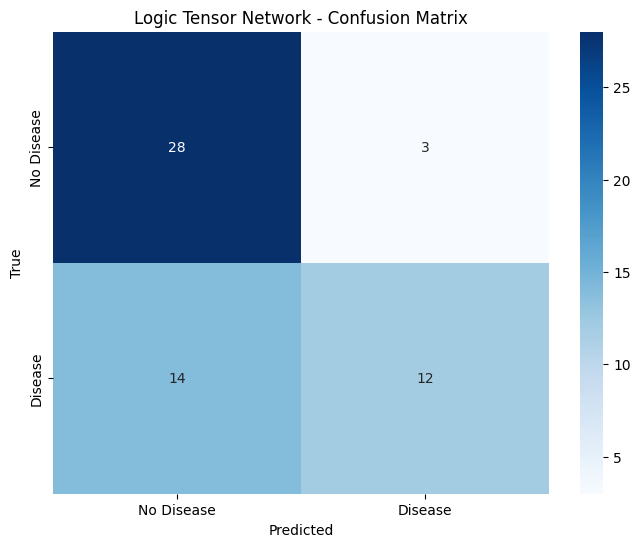

In [147]:
# Function to plot Confusion Matrix
def plot_confusion_matrix(model, X_test, y_test, model_name):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

    with torch.no_grad():
        y_pred = model(X_test_tensor).view(-1, 1).numpy()

    y_pred_binary = (y_pred > 0.5).astype(int)  # Binarize predictions

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot Confusion Matrix for each model
for ModelClass, name in [(DeepProbLogSimulated, "DeepProbLog"),
                         (GNNModel, "Graph Neural Network"),
                         (LTNSimulated, "Logic Tensor Network")]:
    model = ModelClass(X_train.shape[1])
    train_and_evaluate(model, X_train, y_train, X_test, y_test, name)
    plot_confusion_matrix(model, X_test, y_test, name)

In [148]:
# Statistical tests: Wilcoxon Signed-Rank Test and Paired t-Test
accuracy_scores = results_df['Accuracy']
f1_scores = results_df['F1-Score']

# Wilcoxon Signed-Rank Test
_, p_value_wilcoxon = wilcoxon(accuracy_scores, f1_scores)
print(f"Wilcoxon Test p-value: {p_value_wilcoxon}")

# Paired t-Test
_, p_value_ttest = ttest_rel(accuracy_scores, f1_scores)
print(f"Paired t-Test p-value: {p_value_ttest}")

Wilcoxon Test p-value: 0.25
Paired t-Test p-value: 0.3951083652802866


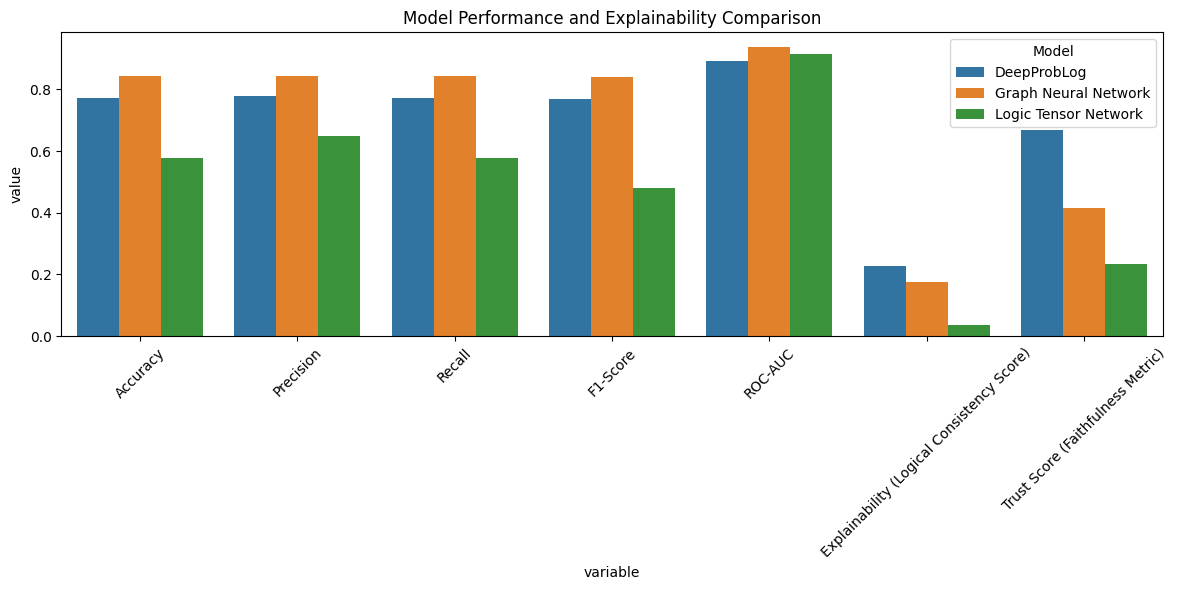

In [149]:
# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars="Model"), x="variable", y="value", hue="Model")
plt.title("Model Performance and Explainability Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()